In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

In [3]:
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
reviewer_model = ChatGroq(model='qwen-2.5-32b')

In [8]:
result = reviewer_model.invoke("classify the given text into positive or negative the chat looks too basic need some additional patameters to be added pls do that return the result in positive or negative words")

In [9]:
result

AIMessage(content='Negative', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 62, 'total_tokens': 64, 'completion_time': 0.01, 'prompt_time': 0.005318242, 'queue_time': 0.227646383, 'total_time': 0.015318242}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-d5a6d116-6bf1-46e6-8636-86a8d19fb444-0', usage_metadata={'input_tokens': 62, 'output_tokens': 2, 'total_tokens': 64})

In [10]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
import fastapi
import openai
from graphviz import Source
from langchain_core.messages import HumanMessage,SystemMessage
from pydantic import BaseModel
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
import io
from IPython.display import Image, display

class MessagesState(TypedDict):
    messages:Annotated[list,add_messages]
    feedback:str
    review:str
    prompt:str
#
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
reviewer_model = ChatGroq(model='qwen-2.5-32b')

# Define prompt
prompt = """
Generate a simple Graphviz DOT diagram for a blog generator workflow. 
The workflow should include:
1. A "Generator Node" that generates the blog.
2. A "Reviewer Node" that reviews the content.
3. If the content is incorrect, it should go back to the "Generator Node".
Output only the DOT code.
"""

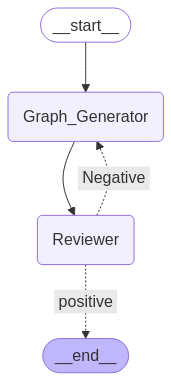

In [ ]:
def Graph_Generator(state:MessagesState):
    system_message_generator = SystemMessage(content="You are a helpful assistant who helps users by generating the Lang Graph work flow based on the requirement")
    # Call GPT-4-turbo API
    if state['feedback'] == '':
        
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": [system_message_generator] + state['prompt']}]
        )
        # Extract the DOT code
        dot_code = response["choices"][0]["message"]["content"]
        lines = dot_code.split("\n")[1:-1]
        extracted_dot = "\n".join(lines)

        # Pass extracted content to Graphviz
        graph = Source(extracted_dot, format="pdf")
        graph.render("graph_output")  # Saves as graph_output.pdf
        
        #graph.view()  # Open the generated PDF
    else:
        response = openai.ChatCompletion.create(
            model="gpt-4-turbo",
            messages=[{"role": "user", "content": [system_message_generator] + state['prompt'] + state['feedback']}]
        )
        # Extract the DOT code
        dot_code = response["choices"][0]["message"]["content"]
        lines = dot_code.split("\n")[1:-1]
        extracted_dot = "\n".join(lines)

        # Pass extracted content to Graphviz
        graph = Source(extracted_dot, format="pdf")
        graph.render("graph_output")  # Saves as graph_output.pdf
        #graph.view()  # Open the generated PDF

def Reviewer(state: MessagesState):
    system_message_Reviewer = SystemMessage(content="You are a helpful assistant who takes user feedback and categorize the feedback into positive or negative and send the feedback to Generator node if it is negative return the response using words positive or negative")
    
    reviewer_model.invoke([system_message_Reviewer] + state['feedback'])
    
    return{'review':reviewer_model.content}

#generating the graph
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("Graph_Generator",Graph_Generator)
graph_builder.add_node("Reviewer",Reviewer)
#graph_builder.add_node("Check_Review",Check_Review)

#adding edges
graph_builder.add_edge(START,"Graph_Generator")
graph_builder.add_edge("Graph_Generator","Reviewer")
#graph_builder.add_edge("Reviewer","Check_Review")
graph_builder.add_conditional_edges("Reviewer",Reviewer,{"Negative":"Graph_Generator","positive":END})

WorkFlow_Graph = graph_builder.compile()

display(Image(WorkFlow_Graph.get_graph().draw_mermaid_png())) 
    
    
